In [1]:
!pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
!pip install robustness

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import sys
sys.path.append('/content/drive/MyDrive')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import matplotlib.pyplot as plt
from robustness import datasets, cifar_models
import attacker, utils

In [6]:
HPARAMS = {
  "PATCH_SIZE": 5,
  "LAMBDA": 10,
  "BATCH_SIZE" : 10,
  "NUM_WORKERS": 1,
  "DATA_AUG": False
}

In [7]:
image_dim = 32
classes = {-1: 'noise',
  0: 'airplane',
  1: 'automobile',
  2: 'bird',
  3: 'cat',
  4: 'deer',
  5: 'dog',
  6: 'frog',
  7: 'horse',
  8: 'ship',
  9: 'truck'}
device = torch.device("cuda")

In [8]:
dataset = datasets.CIFAR('/data/')
_, test_loader = dataset.make_loaders(workers= HPARAMS["NUM_WORKERS"], 
                                      batch_size=HPARAMS["BATCH_SIZE"], 
                                      data_aug=HPARAMS["DATA_AUG"])
data_iterator = enumerate(test_loader)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [9]:
clf = cifar_models.ResNet50(num_classes = 10)
atk = attacker.AttackerModel(clf, dataset)

In [10]:
model = utils.load_model(atk=atk, pt_file="./drive/MyDrive/CIFAR.pt")
model = model.to(device)
model.eval()
pass

Loading checkpoint
Loaded checkpoint at epoch 153


In [11]:
def corrupt_image(images, PATCH_SIZE):
  #Generate random locations for both x and y
  locations = np.random.randint(low = 0, high = images.shape[-1] - PATCH_SIZE, size=(images.shape[0], 2))
  masks = torch.zeros(size = images.size())

  for i in range(images.shape[0]):
    x, y = locations[i, 0], locations[i, 1]
    mean = torch.mean(images[i])
    patch_size = torch.Size([images[i].size(dim=0), PATCH_SIZE, PATCH_SIZE])
    patch = mean*torch.ones(size = patch_size)

    images[i, :, x:x+PATCH_SIZE, y:y+PATCH_SIZE] = patch
    masks[i, :, x:x+PATCH_SIZE, y:y+PATCH_SIZE] = 1

  return images, masks

In [12]:
def loss_wrapper(corrupt, mask, normalizer, lambda_value):
  
  #torch.nn.functional.cross_entropy(model_preds, target, reduction='none')
  criterion = torch.nn.CrossEntropyLoss(reduction='none')

  def inpainting_loss(net, inpainted, target):
      model_preds = net(normalizer(inpainted), fake_relu=True)
      l2_magnitude = torch.mul(torch.sub(corrupt, inpainted), 1 - mask)
      l2 = torch.pow(l2_magnitude, 2)
      l2 = torch.mean(l2, dim=(1,2,3))

      ce_loss = criterion(model_preds, target) 
      regularization_term = lambda_value * l2
      loss = ce_loss + regularization_term
      return loss

  return inpainting_loss

In [13]:
_, (image, target) = next(data_iterator)
corrupt, mask = corrupt_image(image.clone(), PATCH_SIZE = HPARAMS["PATCH_SIZE"])
custom_loss = loss_wrapper(corrupt.to(device), mask.to(device), model.normalizer, lambda_value = HPARAMS["LAMBDA"])

In [14]:
_,inpainted = model(corrupt.to(device), target.clone().to(device), 
                       eps=200, step_size=.1,
                       iters=200, normalize=False,
                       custom_loss=custom_loss)

In [15]:
concatenated_samples = [image.cpu(),corrupt.cpu(), inpainted.detach().cpu()]
row_titles = ["Original", "Corrupted", "Inpainted"]

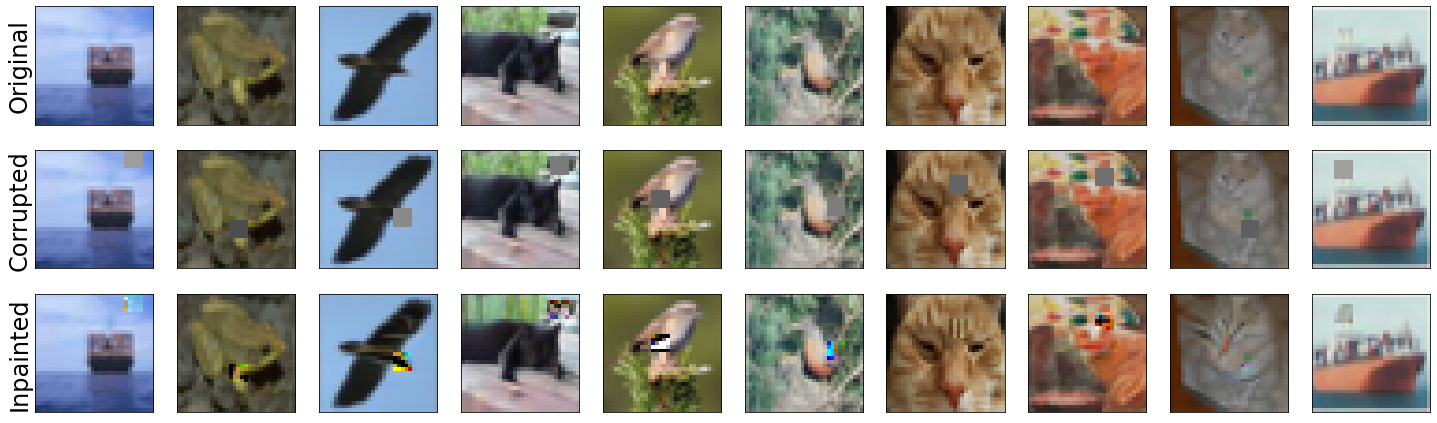

In [17]:
utils.plot_all_samples(concatenated_samples, row_titles,r=3)